In [1]:
using Printf
using Random
using LinearAlgebra
using PlotlyJS
rng = MersenneTwister(18);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17818747001878782080\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9649805310977610849\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17818747001878782080\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
n = 3 # In 3D

Q = rand(n,n)
Q,R = qr(Q)
Λ = diagm(0 => Float32[2.0^(-i) for i=0:n-1])
A = Q * Λ * Q'
# The e-vectors are the columns of Q.

Diagonal(Λ)

3×3 Diagonal{Float32,Array{Float32,1}}:
 1.0   ⋅    ⋅ 
  ⋅   0.5   ⋅ 
  ⋅    ⋅   0.25

In [3]:
μ0 = Λ[1,1]
μ = μ0 * 0.8
# Our initial approximation of an eigenvalue of interest

println("Exact answer: ", μ0)
println("Initial guess: ", μ)

qk = rand(rng, n)
qk /= norm(qk)

# Estimating C fit
function C_estimate(A, μ0, μ_, qk_)
    μ = μ_
    qk = qk_
    error0 = 0
    for k=1:2
        zk = (A - μ * I) \ qk
        qk = zk/norm(zk)      # Normalize e-vector
        μ = dot(qk, A * qk)   # E-value approximation
        error0 = abs(μ-μ0)
    end
    zk = (A - μ * I) \ qk
    qk = zk/norm(zk)      # Normalize e-vector
    μ = dot(qk, A * qk)   # E-value approximation
    error1 = abs(μ-μ0)
    ϵ = sqrt(error1/error0)
    return error0 / ϵ
end

c_fit = C_estimate(A, μ0, μ, qk)
error_old = -1

for k=1:5
    zk = (A - μ * I) \ qk
    qk = zk/norm(zk)      # Normalize e-vector
    μ = dot(qk, A * qk)   # E-value approximation
    @printf "Iteration: %1d | e-value: %10.8f | error: %7.1e " k μ abs(μ-μ0)
    if k>1
        @printf " (estim. %7.1e)\n" c_fit*(error_old/c_fit)^3
    else
        @printf "\n"
    end
    error_old = abs(μ-μ0)
end

Exact answer: 1.0
Initial guess: 0.8
Iteration: 1 | e-value: 0.91737444 | error: 8.3e-02 
Iteration: 2 | e-value: 0.99648944 | error: 3.5e-03  (estim. 2.2e-03)
Iteration: 3 | e-value: 0.99999983 | error: 1.7e-07  (estim. 1.7e-07)
Iteration: 4 | e-value: 1.00000000 | error: 3.3e-16  (estim. 2.0e-20)
Iteration: 5 | e-value: 1.00000000 | error: 1.1e-16  (estim. 1.5e-46)


In [4]:
# Let's plot the Rayleigh quotient to observe that grad r = 0
# at all e-values.

N = 32
u = LinRange(0, 2π, N)
v = LinRange(0, π, N)

x = cos.(u) * sin.(v)'
y = sin.(u) * sin.(v)'
z = repeat(cos.(v)',outer=[N, 1])

r = zeros(N,N)
for i=1:N, j=1:N
    # The point q is on the surface of the unit sphere
    q = [x[i,j] y[i,j] z[i,j]]
    # Rayleigh-quotient at this point
    r[i,j] = dot(q, A * transpose(q))
end

P = 1.1*vcat(Q',-Q') # Increase the radius a bit

6×3 Array{Float64,2}:
 -0.0701435  -0.936581  -0.572623
  0.989825    0.194153  -0.438806
  0.474685   -0.543251   0.830393
  0.0701435   0.936581   0.572623
 -0.989825   -0.194153   0.438806
 -0.474685    0.543251  -0.830393

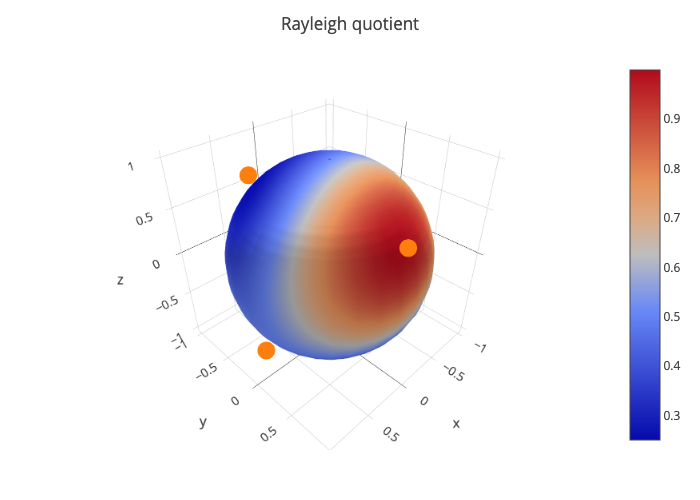

In [5]:
t = scatter3d(x=P[:,1], y=P[:,2], z=P[:,3],
    mode="markers", marker_size=10)

s = surface(x=x, y=y, z=z, surfacecolor=r)

l = Layout(title="Rayleigh quotient", 
    aspectratio=attr(x=1, y=1, z=1),
    scene_dragmode="orbit")

plot([s, t], l)